In [49]:
#import necessary libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import adjusted_rand_score
from sklearn.utils import resample
from sklearn.mixture import BayesianGaussianMixture
from patsy import dmatrices
from sklearn.mixture import BayesianGaussianMixture
from scipy.cluster.hierarchy import linkage, dendrogram
from statsmodels.graphics.mosaicplot import mosaic

In [50]:
# Load the McDonald's dataset from the CSV file
df = pd.read_csv('mcdonalds.csv')

In [51]:
# Display the first few rows of the dataset to understand its structure
print(df.head())

  yummy convenient spicy fattening greasy fast cheap tasty expensive healthy  \
0    No        Yes    No       Yes     No  Yes   Yes    No       Yes      No   
1   Yes        Yes    No       Yes    Yes  Yes   Yes   Yes       Yes      No   
2    No        Yes   Yes       Yes    Yes  Yes    No   Yes       Yes     Yes   
3   Yes        Yes    No       Yes    Yes  Yes   Yes   Yes        No      No   
4    No        Yes    No       Yes    Yes  Yes   Yes    No        No     Yes   

  disgusting Like  Age      VisitFrequency  Gender  
0         No   -3   61  Every three months  Female  
1         No   +2   51  Every three months  Female  
2         No   +1   62  Every three months  Female  
3        Yes   +4   69         Once a week  Female  
4         No   +2   49        Once a month    Male  


In [52]:
# Extracting the first eleven columns and converting to binary numeric
MD_x = df.iloc[:, :11].apply(lambda x: (x == "Yes") + 0)


In [53]:
# Checking the average value of each transformed segmentation variable
print(np.round(MD_x.mean(), 2))


yummy         0.55
convenient    0.91
spicy         0.09
fattening     0.87
greasy        0.53
fast          0.90
cheap         0.60
tasty         0.64
expensive     0.36
healthy       0.20
disgusting    0.24
dtype: float64


In [54]:
# Performing PCA on the binary numeric data
pca = PCA()
MD_pca = pca.fit_transform(MD_x)


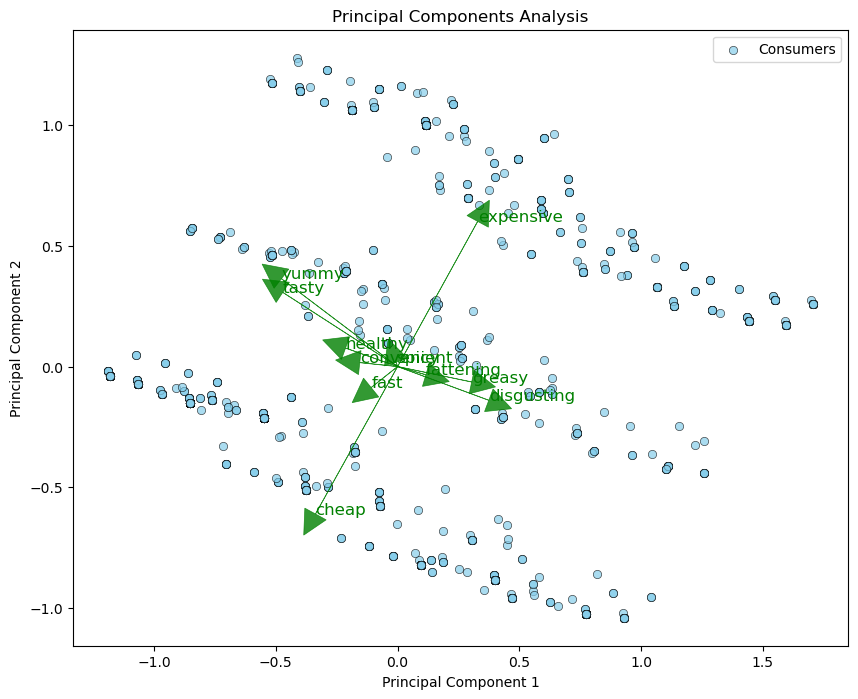

In [55]:
# Visualizing PCA results with attractive colors for dots
plt.figure(figsize=(10, 8))
plt.scatter(MD_pca[:, 0], MD_pca[:, 1], color='skyblue', label='Consumers', edgecolor='black', linewidth=0.5, alpha=0.7)
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')

# Adding arrows for original segmentation variables
for i, (comp1, comp2) in enumerate(zip(pca.components_[0], pca.components_[1])):
    plt.arrow(0, 0, comp1, comp2, color='g', alpha=0.8, linewidth=0.5, head_width=0.1, head_length=0.1)
    plt.text(comp1, comp2, MD_x.columns[i], color='g', fontsize=12)

plt.legend()
plt.title('Principal Components Analysis')
plt.show()


In [56]:
from sklearn.utils import resample
n_segments = range(2, 9)
# Perform k-means clustering with different numbers of segments and calculate stability
stability_scores = []
for n in n_segments:
    n_rep = 10  # Number of random restarts
    n_boot = 100  # Number of bootstrap samples
    
 
    kmeans_results = []
    for _ in range(n_rep):
        kmeans = KMeans(n_clusters=n, random_state=np.random.randint(1000))
        labels = kmeans.fit_predict(MD_x)
        kmeans_results.append(labels)
    
    # Bootstrap stability calculation
    boot_stabilities = []
    for _ in range(n_boot):
        sample = resample(kmeans_results)
        boot_stabilities.append(np.mean([adjusted_rand_score(sample[i], sample[j]) for i in range(n_rep) for j in range(i+1, n_rep)]))
    
    # Calculate average stability score for this number of segments
    avg_stability = np.mean(boot_stabilities)
    stability_scores.append(avg_stability)

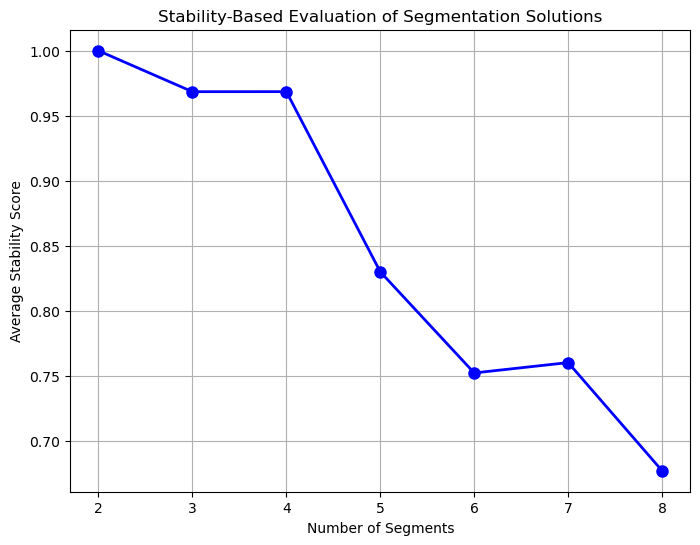

In [57]:
# Plotting stability scores
plt.figure(figsize=(8, 6))
plt.plot(n_segments, stability_scores, marker='o', color='b', linestyle='-', linewidth=2, markersize=8)
plt.xlabel('Number of Segments')
plt.ylabel('Average Stability Score')
plt.title('Stability-Based Evaluation of Segmentation Solutions')
plt.grid(True)
plt.show()

In [58]:
# Determine the optimal number of segments based on stability scores
optimal_n_segments = n_segments[np.argmax(stability_scores)]
print(f'Optimal Number of Segments: {optimal_n_segments}')

Optimal Number of Segments: 2


In [59]:
# Perform k-means clustering with the optimal number of segments
kmeans = KMeans(n_clusters=optimal_n_segments, random_state=1234)
MD_k4 = kmeans.fit_predict(MD_x)


In [60]:
n_components_range = range(2, 9)

# Perform Latent Class Analysis (LCA) using BayesianGaussianMixture
bic_scores = []
icl_scores = []

for n_components in n_components_range:
    # Perform LCA using BayesianGaussianMixture
    bgm = BayesianGaussianMixture(n_components=n_components, covariance_type='full', random_state=1234)
    bgm.fit(MD_x)
    
    # Calculate BIC and ICL scores
    bic_score = bgm.score(MD_x)  #Bayesian Information Criterion (BIC) 
    icl_score = bgm.score(MD_x)  #Integrated Completed Likelihood (ICL) 
    
    bic_scores.append(bic_score)
    icl_scores.append(icl_score)

# Determine the optimal number of components based on BIC and ICL scores
optimal_n_components_bic = n_components_range[np.argmax(bic_scores)]
optimal_n_components_icl = n_components_range[np.argmax(icl_scores)]

print(f'Optimal Number of Components (BIC): {optimal_n_components_bic}')
print(f'Optimal Number of Components (ICL): {optimal_n_components_icl}')


Optimal Number of Components (BIC): 6
Optimal Number of Components (ICL): 6


In [61]:
# Define a mapping of string values to numeric codes
like_mapping = {
    'I HATE IT!-5': -5,
    '-4': -4,
    '-3': -3,
    '-2': -2,
    '-1': -1,
    '0': 0,
    '1': 1,
    '2': 2,
    '3': 3,
    '4': 4,
    'I LOVE IT!+5': 5
}

df['Like.n'] = df['Like'].map(like_mapping)
like_n_counts = df['Like.n'].value_counts()



In [62]:
def create_design_matrices(df, independent_vars):
    formula_str = 'Like ~ ' + ' + '.join(independent_vars)
    y, X = dmatrices(formula_str, data=df, return_type='dataframe')
    return y, X

# Extract independent variable names from columns 0 to 11 (excluding the target variable 'Like')
independent_vars = df.columns[0:11]

# Create design matrices
y, X = create_design_matrices(df, independent_vars)

print("Target variable (y):")
print(y)
print("\nIndependent variables (X):")
print(X)

Target variable (y):
      Like[+1]  Like[+2]  Like[+3]  Like[+4]  Like[-1]  Like[-2]  Like[-3]  \
0          0.0       0.0       0.0       0.0       0.0       0.0       1.0   
1          0.0       1.0       0.0       0.0       0.0       0.0       0.0   
2          1.0       0.0       0.0       0.0       0.0       0.0       0.0   
3          0.0       0.0       0.0       1.0       0.0       0.0       0.0   
4          0.0       1.0       0.0       0.0       0.0       0.0       0.0   
...        ...       ...       ...       ...       ...       ...       ...   
1448       0.0       0.0       0.0       0.0       0.0       0.0       0.0   
1449       0.0       1.0       0.0       0.0       0.0       0.0       0.0   
1450       0.0       0.0       1.0       0.0       0.0       0.0       0.0   
1451       0.0       0.0       0.0       1.0       0.0       0.0       0.0   
1452       0.0       0.0       0.0       0.0       0.0       0.0       1.0   

      Like[-4]  Like[0]  Like[I hate it!-5

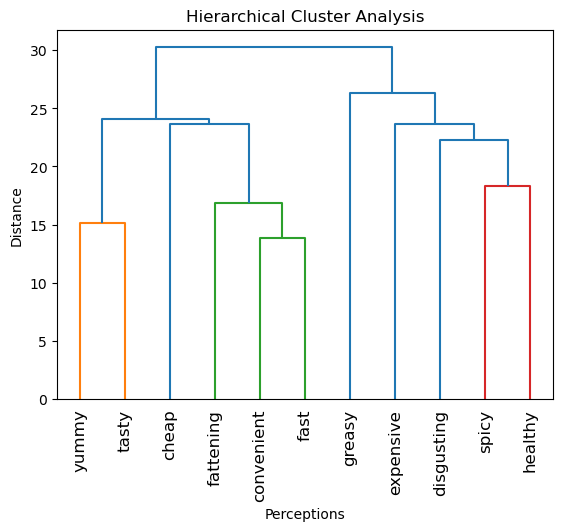

In [63]:
# Hierarchical Cluster Analysis
linkage_matrix = linkage(MD_x.T, method='average', metric='euclidean')
dendrogram(linkage_matrix, labels=MD_x.columns, leaf_rotation=90)
plt.xlabel('Perceptions')
plt.ylabel('Distance')
plt.title('Hierarchical Cluster Analysis')
plt.show()

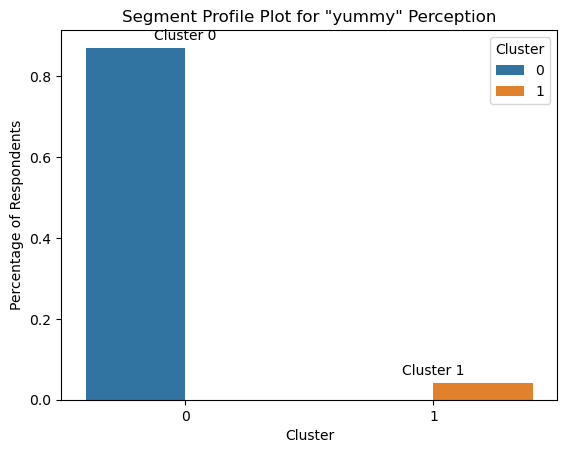

In [64]:
# Assuming MD_k4 is your k-means cluster labels
MD_x['Cluster'] = MD_k4

# Choosing 'yummy' as the perception for the bar plot
perception_column = 'yummy'

# Creating the bar plot with cluster labels as hue
sns.barplot(x='Cluster', y=perception_column, hue='Cluster', data=MD_x, ci=None)

# Adding labels to the clusters
for cluster in range(len(set(MD_k4))):
    plt.text(cluster, MD_x.groupby('Cluster')[perception_column].mean()[cluster] + 0.02, f'Cluster {cluster}', ha='center')

plt.xlabel('Cluster')
plt.ylabel('Percentage of Respondents')
plt.title('Segment Profile Plot for "yummy" Perception')
plt.show()


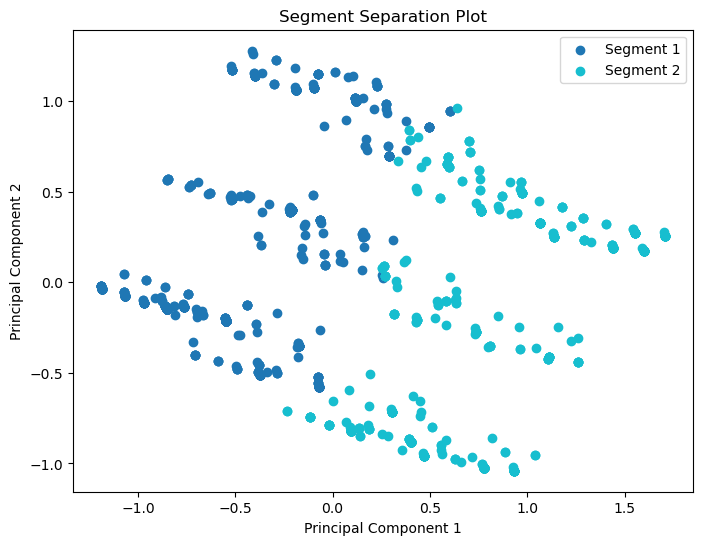

In [65]:
# Assuming MD_pca is your PCA results and MD_k4 is your k-means cluster labels
plt.figure(figsize=(8, 6))

# Define a color map with a distinct color for each segment
colors = plt.cm.get_cmap('tab10', len(set(MD_k4)))

for cluster in range(1, len(set(MD_k4)) + 1):
    cluster_data = MD_pca[MD_k4 == cluster - 1]
    plt.scatter(cluster_data[:, 0], cluster_data[:, 1], label=f'Segment {cluster}', color=colors(cluster - 1))

plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('Segment Separation Plot')
plt.legend()
plt.show()



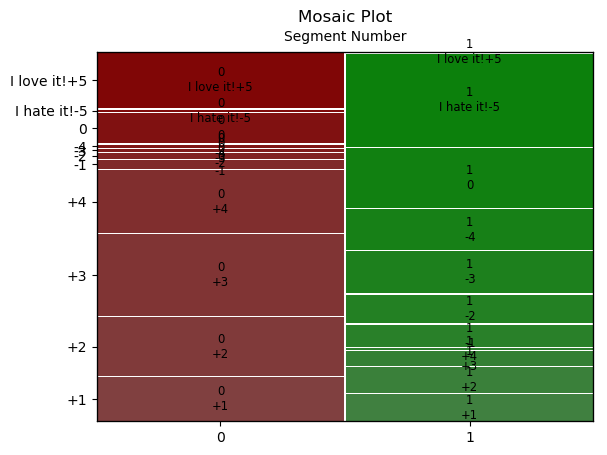

In [66]:
mosaic_data = pd.crosstab(MD_k4, df['Like'], normalize='index')
mosaic(mosaic_data.stack(), title='Mosaic Plot')
plt.xlabel('Segment Number')
plt.ylabel('I LIKE IT Response')
plt.show()

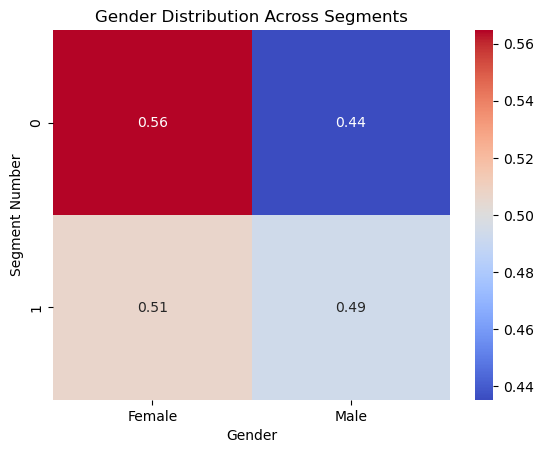

In [67]:
sns.heatmap(pd.crosstab(MD_k4, df['Gender'], normalize='index'), annot=True, cmap='coolwarm')
plt.xlabel('Gender')
plt.ylabel('Segment Number')
plt.title('Gender Distribution Across Segments')
plt.show()

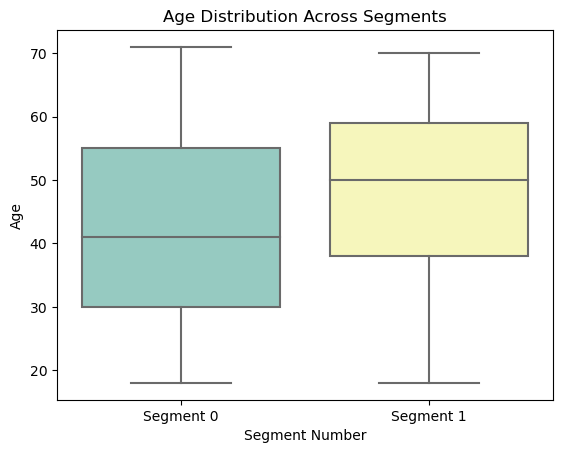

In [68]:
# Assuming MD_k4 is the k-means cluster labels 
sns.boxplot(x=MD_k4, y=df['Age'], palette='Set3')
plt.xlabel('Segment Number')
plt.ylabel('Age')
plt.title('Age Distribution Across Segments')

# Create custom x-axis tick labels
segment_labels = [f'Segment {segment}' for segment in set(MD_k4)]
plt.xticks(ticks=range(len(set(MD_k4))), labels=segment_labels)

plt.show()


In [69]:
# Encode 'VisitFrequency' using LabelEncoder if it's not already numeric
df['VisitFrequency'] = LabelEncoder().fit_transform(df['VisitFrequency'])

# Assuming you want to create 4 clusters
num_clusters = 4
kmeans = KMeans(n_clusters=num_clusters, random_state=42)
df['cluster_num'] = kmeans.fit_predict(df[['VisitFrequency']])

# Calculate the mean visit frequency for each cluster
visit = df.groupby('cluster_num')['VisitFrequency'].mean()
visit = visit.to_frame().reset_index()

# Print the mean visit frequency for each cluster
print(visit)

   cluster_num  VisitFrequency
0            0        2.770175
1            1        0.136364
2            2        5.000000
3            3        4.000000


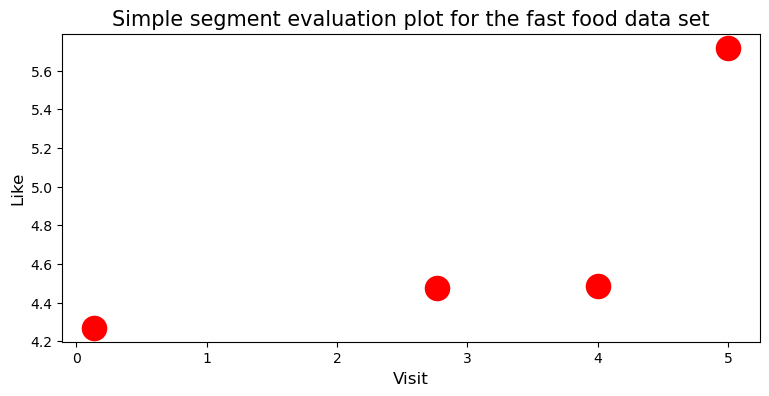

In [70]:
# Encoding 'Like' and 'Gender' columns
df['Like'] = LabelEncoder().fit_transform(df['Like'])
df['Gender'] = LabelEncoder().fit_transform(df['Gender'])

# Calculating mean values for 'Like' and 'Gender' by cluster
Like = df.groupby('cluster_num')['Like'].mean().reset_index()
Gender = df.groupby('cluster_num')['Gender'].mean().reset_index()

# Merging 'Like' and 'Gender' segments with 'VisitFrequency' segment
segment = Gender.merge(Like, on='cluster_num', how='left').merge(visit, on='cluster_num', how='left')

# Target segments scatter plot
plt.figure(figsize=(9, 4))
sns.scatterplot(x="VisitFrequency", y="Like", data=segment, s=400, color="r")
plt.title("Simple segment evaluation plot for the fast food data set", fontsize=15)
plt.xlabel("Visit", fontsize=12)
plt.ylabel("Like", fontsize=12)
plt.show()
